学習済みのネットワークとは、大規模なデータセットで訓練されたあと、保存されたネットワークのこと。<br>

ここでは、VGG16アーキテクチャを使用する。<br>

学習済みのネットワークを使用するには、以下の２つがある。<br>
1. 特徴抽出<br>
2. ファインチューニング<br>

画像分類に使用されるCNNは２つの部分で構成されている。<br>
CNNは、一連のプーリング層と畳み込み層で始まり、全結合分類器で終わる。<br>

### VGG16モデル

In [10]:
import keras
keras.__version__

'2.1.6'

In [11]:
from keras.applications import VGG16

conv_base = VGG16(
        weights = 'imagenet', # 重みのチェックポイント
        include_top = False, # 全結合分類器を含めるかどうか
        input_shape=(150,150,3)) # 引数を指定しない場合、ネットワークは任意のサイズを処理

In [12]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### データ拡張を行わない高速な特徴抽出

In [13]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [14]:
base_dir = '/Users/Takanori/Downloads/cats_and_dogs_small'

In [15]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [16]:
datagen = ImageDataGenerator(rescale=1./255) # データの作成
batch_size = 20 # バッチサイズ

In [17]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        # print(inputs_batch)
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [18]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512)) # 2000行と4*4*512の特徴量に変換
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [19]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6330 - acc: 0.6575 - val_loss: 0.4504 - val_acc: 0.8310
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4424 - acc: 0.8080 - val_loss: 0.3666 - val_acc: 0.8570
Epoch 3/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3661 - acc: 0.8430 - val_loss: 0.3365 - val_acc: 0.8610
Epoch 4/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3199 - acc: 0.8650 - val_loss: 0.3007 - val_acc: 0.8830
Epoch 5/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2877 - acc: 0.8810 - val_loss: 0.2843 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2706 - acc: 0.8895 - val_loss: 0.2717 - val_acc: 0.8920
Epoch 7/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2483 - acc: 0.9065 - val_loss: 0.2629 - val_acc: 0.9000
Epoch 8/30
200

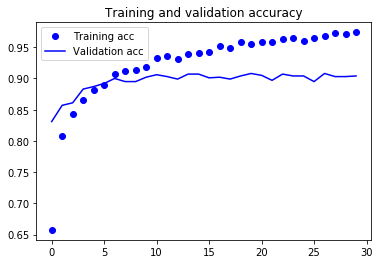

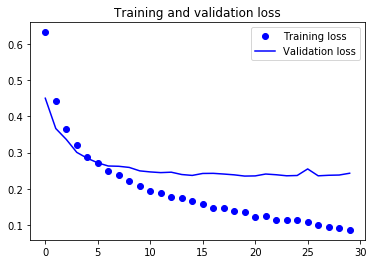

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()